In [1]:
import numpy as np
import tensorflow as tf

np.random.seed(2019)
tf.set_random_seed(2019)

class MLP:
    def __init__(self, n_hidden=30, n_output=1):
        self.n_hidden = n_hidden
        self.n_output = n_output

        # define placeholders for training MLP
        self.x = tf.placeholder(tf.float32, shape=[None, 1])
        self.y = tf.placeholder(tf.float32, shape=[None, 1])
        self.dropout_rate = tf.placeholder(tf.float32)
        self.lr = tf.placeholder(tf.float32)

        self.predictions, self.loss, self.opt = self.build_graph(n_hidden=self.n_hidden, n_output=self.n_output)

    def build_graph(self, n_hidden=30, n_output=1):
        """
        Build computational graph for toy dataset with dropout

        Args:
            n_hidden: the number of hidden units in MLP.
            n_output: the size of output layer (=1)

        Returns:
            prob: probability of prediction (m, 1)
            loss: corss entropy loss
            learning rate: learning rate for optimizer (ex. SGD, RMSprop, Adam, etc.)
        """

        with tf.variable_scope('mlp'):
            # initializers for weight and bias
            w_init = tf.contrib.layers.variance_scaling_initializer()
            b_init = tf.constant_initializer(0.0)

            # 1st hidden layer (input dimension --> n_hidden)
            w0 = tf.get_variable('w0', [self.x.get_shape()[1], n_hidden], initializer=w_init)
            b0 = tf.get_variable('b0', [n_hidden], initializer=b_init)
            h0 = tf.matmul(self.x, w0) + b0
            h0 = tf.nn.relu(h0)
            h0 = tf.nn.dropout(h0, rate=self.dropout_rate)

            # 2nd hidden layer (n_hidden --> n_hidden)
            """
            Please implement the second fully connected layer
            with (n_hidden --> n_hidden)
            """
            w1 = tf.get_variable('w1', [h0.get_shape()[1], n_hidden], initializer=w_init)  #######################################
            b1 = tf.get_variable('b1', [n_hidden], initializer=b_init)
            h1 = tf.matmul(h0, w1) + b1
            h1 = tf.nn.relu(h1)
            h1 = tf.nn.dropout(h1, rate=self.dropout_rate)
            
            # 3nd hidden layer (n_hidden --> n_hidden)
            w2 = tf.get_variable('w2', [h1.get_shape()[1], n_hidden], initializer=w_init)
            b2 = tf.get_variable('b2', [n_hidden], initializer=b_init)
            h2 = tf.matmul(h1, w2) + b2
            h2 = tf.nn.relu(h2)
            h2 = tf.nn.dropout(h2, rate=self.dropout_rate)

            # output layer (n_hidden --> n_output)
            wo = tf.get_variable('wo', [h2.get_shape()[1], n_output], initializer=w_init)
            bo = tf.get_variable('bo', [n_output], initializer=b_init)
            predictions = tf.matmul(h2, wo) + bo
            
            # we don't need probability --> just regression problems
            # prob = tf.nn.softmax(logit, axis=1)
            # loss
            # loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
            #    logits=logit, labels=self.y))
            """
            Please implement the Mean Squared Loss function
            """
            # loss
            #loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logit, labels=self.y))  #############################
            loss = tf.reduce_mean(tf.square(predictions - self.y)) 
            
            
            # optimizer
            opt = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(loss)
        return predictions, loss, opt

In [2]:
mlp = MLP()
sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True)))
sess.run(tf.global_variables_initializer())

W0730 22:42:33.205512  3216 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [3]:
"""
Toy dataset = sine function with standard Gaussian noise ~ N(0, 1^2)
Training data (1-dimensional) --> only from -3 to 3

Test data (1-dimensional) --> from -6 to 6
You don't need to handle this part.
"""
x_train = np.linspace(-3, 3.2, 31, endpoint=False)
noise_train = 0.2 * np.random.randn(31)
y_train = np.sin(x_train) + noise_train

x_train, y_train = np.expand_dims(x_train, -1), np.expand_dims(y_train, -1)

x_test = np.linspace(-6, 6.2, 61, endpoint=False)
noise_test = np.random.randn(61)
y_test = np.sin(x_test) + 0.2 * noise_test

x_test, y_test = np.expand_dims(x_test, -1), np.expand_dims(y_test, -1)

In [4]:
from matplotlib import pyplot as plt
plt.figure()
plt.xlabel("$x$")
plt.ylabel("$y = \sin x + 0.2 \epsilon$ with $\epsilon$ ~ $N(0,1^2)$")
plt.plot(x_train, y_train, 'bo', color='black', label="Train data")
plt.plot(x_test, y_test, 'bo', color='red', label="Test data")
plt.ylim([-1.5, 1.5])
plt.legend(loc='best')
plt.show()

<Figure size 640x480 with 1 Axes>

In [5]:
def train(net, sess, num_epoch=3000):
    # iterating epoch
    for epoch in range(num_epoch):
        # here we use batch gradient descent since the data size is small!!
        #feed_dict = # <-- Please implement this part!      ##########################################################
        
        feed_dict = {net.x: x_train,
                     net.y: y_train,
                     net.dropout_rate: 0.3, 
                     net.lr : 1e-3}        
        
        avg_loss, _ = sess.run([net.loss, net.opt], feed_dict=feed_dict)
        print ('Epoch: ', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_loss))
    print ("Learning finished")
    return

In [6]:
def evaluate(net, sess, T=50):
    repeat_predictions = []
    """
    Important thing!!

    Here, repeat prediction has size of (T, num, 1)
    T: How many runs for measuring uncertainty?
    n_test: the number of test data samples
    1: dimensions of outputs
    
    You don't need to modify here
    """
    for i in range(T):
        repeat_predictions.append(sess.run(net.predictions, feed_dict={net.x: x_test,
                                                                       net.y: y_test,
                                                                       net.dropout_rate: 0.3}))
    return repeat_predictions

In [7]:
train(mlp, sess)
repeat_predictions = evaluate(mlp, sess)             ##########################################################
repeat_predictions = np.array(repeat_predictions)

Epoch:  0001 cost = 15.845354080
Epoch:  0002 cost = 17.199279785
Epoch:  0003 cost = 17.028057098
Epoch:  0004 cost = 16.257877350
Epoch:  0005 cost = 23.250301361
Epoch:  0006 cost = 20.327487946
Epoch:  0007 cost = 27.972572327
Epoch:  0008 cost = 11.167693138
Epoch:  0009 cost = 18.905139923
Epoch:  0010 cost = 7.770452023
Epoch:  0011 cost = 6.882071018
Epoch:  0012 cost = 19.635848999
Epoch:  0013 cost = 8.072469711
Epoch:  0014 cost = 11.030523300
Epoch:  0015 cost = 14.258452415
Epoch:  0016 cost = 8.029352188
Epoch:  0017 cost = 15.923525810
Epoch:  0018 cost = 10.634839058
Epoch:  0019 cost = 5.745118618
Epoch:  0020 cost = 4.285914898
Epoch:  0021 cost = 6.611626625
Epoch:  0022 cost = 6.501475811
Epoch:  0023 cost = 13.894446373
Epoch:  0024 cost = 13.804351807
Epoch:  0025 cost = 8.690799713
Epoch:  0026 cost = 6.806662083
Epoch:  0027 cost = 7.870424271
Epoch:  0028 cost = 9.197971344
Epoch:  0029 cost = 4.421690941
Epoch:  0030 cost = 7.367815018
Epoch:  0031 cost = 9.21

Epoch:  0352 cost = 0.812726796
Epoch:  0353 cost = 0.698221624
Epoch:  0354 cost = 0.637169003
Epoch:  0355 cost = 0.653263807
Epoch:  0356 cost = 1.145747185
Epoch:  0357 cost = 0.841300786
Epoch:  0358 cost = 1.342254162
Epoch:  0359 cost = 0.871057153
Epoch:  0360 cost = 1.261721373
Epoch:  0361 cost = 0.574039221
Epoch:  0362 cost = 0.546538651
Epoch:  0363 cost = 1.345631242
Epoch:  0364 cost = 0.929067433
Epoch:  0365 cost = 0.800243914
Epoch:  0366 cost = 0.728095531
Epoch:  0367 cost = 0.612740219
Epoch:  0368 cost = 0.846579731
Epoch:  0369 cost = 0.770938694
Epoch:  0370 cost = 0.816460252
Epoch:  0371 cost = 1.392279744
Epoch:  0372 cost = 0.927534759
Epoch:  0373 cost = 0.603349328
Epoch:  0374 cost = 0.730894983
Epoch:  0375 cost = 1.276010871
Epoch:  0376 cost = 1.207664967
Epoch:  0377 cost = 0.726414979
Epoch:  0378 cost = 0.845100641
Epoch:  0379 cost = 1.012740016
Epoch:  0380 cost = 0.609475076
Epoch:  0381 cost = 0.696109235
Epoch:  0382 cost = 0.741589308
Epoch:  

Epoch:  0705 cost = 0.672625184
Epoch:  0706 cost = 0.459857941
Epoch:  0707 cost = 0.409136444
Epoch:  0708 cost = 0.526816189
Epoch:  0709 cost = 0.459197402
Epoch:  0710 cost = 0.540910006
Epoch:  0711 cost = 0.534210563
Epoch:  0712 cost = 0.730210602
Epoch:  0713 cost = 0.498266906
Epoch:  0714 cost = 0.685188949
Epoch:  0715 cost = 0.278822958
Epoch:  0716 cost = 0.574431658
Epoch:  0717 cost = 0.398619831
Epoch:  0718 cost = 0.479920357
Epoch:  0719 cost = 0.394552797
Epoch:  0720 cost = 0.431663126
Epoch:  0721 cost = 0.578904450
Epoch:  0722 cost = 0.332481235
Epoch:  0723 cost = 0.476618797
Epoch:  0724 cost = 0.391725659
Epoch:  0725 cost = 0.457019746
Epoch:  0726 cost = 0.680339813
Epoch:  0727 cost = 0.574954629
Epoch:  0728 cost = 0.455543697
Epoch:  0729 cost = 0.455828160
Epoch:  0730 cost = 0.448541135
Epoch:  0731 cost = 0.520442665
Epoch:  0732 cost = 0.448208272
Epoch:  0733 cost = 0.417221010
Epoch:  0734 cost = 0.499630362
Epoch:  0735 cost = 0.322417051
Epoch:  

Epoch:  1063 cost = 0.315283239
Epoch:  1064 cost = 0.434944332
Epoch:  1065 cost = 0.382167518
Epoch:  1066 cost = 0.241335690
Epoch:  1067 cost = 0.308714092
Epoch:  1068 cost = 0.315054923
Epoch:  1069 cost = 0.316065848
Epoch:  1070 cost = 0.749013960
Epoch:  1071 cost = 0.396668762
Epoch:  1072 cost = 0.393941820
Epoch:  1073 cost = 0.459526688
Epoch:  1074 cost = 0.557607234
Epoch:  1075 cost = 0.302991301
Epoch:  1076 cost = 0.270718306
Epoch:  1077 cost = 0.419684827
Epoch:  1078 cost = 0.337528467
Epoch:  1079 cost = 0.488693595
Epoch:  1080 cost = 0.297580659
Epoch:  1081 cost = 0.286908478
Epoch:  1082 cost = 0.425688356
Epoch:  1083 cost = 0.425228417
Epoch:  1084 cost = 0.277424544
Epoch:  1085 cost = 0.538436770
Epoch:  1086 cost = 0.337151796
Epoch:  1087 cost = 0.406889141
Epoch:  1088 cost = 0.264365971
Epoch:  1089 cost = 0.350362927
Epoch:  1090 cost = 0.223401338
Epoch:  1091 cost = 0.265886128
Epoch:  1092 cost = 0.320633709
Epoch:  1093 cost = 0.362551838
Epoch:  

Epoch:  1410 cost = 0.333807647
Epoch:  1411 cost = 0.282380402
Epoch:  1412 cost = 0.483049691
Epoch:  1413 cost = 0.338398784
Epoch:  1414 cost = 0.266462505
Epoch:  1415 cost = 0.433487087
Epoch:  1416 cost = 0.381877780
Epoch:  1417 cost = 0.358028203
Epoch:  1418 cost = 0.518732488
Epoch:  1419 cost = 0.314498454
Epoch:  1420 cost = 0.345140696
Epoch:  1421 cost = 0.295767277
Epoch:  1422 cost = 0.297800303
Epoch:  1423 cost = 0.288938761
Epoch:  1424 cost = 0.362237751
Epoch:  1425 cost = 0.363800824
Epoch:  1426 cost = 0.423141152
Epoch:  1427 cost = 0.407756239
Epoch:  1428 cost = 0.396540314
Epoch:  1429 cost = 0.317975938
Epoch:  1430 cost = 0.267244011
Epoch:  1431 cost = 0.267547101
Epoch:  1432 cost = 0.487366557
Epoch:  1433 cost = 0.404145658
Epoch:  1434 cost = 0.338185072
Epoch:  1435 cost = 0.325258255
Epoch:  1436 cost = 0.332300693
Epoch:  1437 cost = 0.363326907
Epoch:  1438 cost = 0.279702157
Epoch:  1439 cost = 0.292757392
Epoch:  1440 cost = 0.258981526
Epoch:  

Epoch:  1750 cost = 0.387617141
Epoch:  1751 cost = 0.366196781
Epoch:  1752 cost = 0.329410762
Epoch:  1753 cost = 0.295425475
Epoch:  1754 cost = 0.341280371
Epoch:  1755 cost = 0.232363164
Epoch:  1756 cost = 0.293572009
Epoch:  1757 cost = 0.302747935
Epoch:  1758 cost = 0.280479133
Epoch:  1759 cost = 0.419721693
Epoch:  1760 cost = 0.299720645
Epoch:  1761 cost = 0.328166395
Epoch:  1762 cost = 0.252363890
Epoch:  1763 cost = 0.248403728
Epoch:  1764 cost = 0.243337423
Epoch:  1765 cost = 0.217607334
Epoch:  1766 cost = 0.265456349
Epoch:  1767 cost = 0.236820012
Epoch:  1768 cost = 0.366920233
Epoch:  1769 cost = 0.350535572
Epoch:  1770 cost = 0.319667518
Epoch:  1771 cost = 0.202270120
Epoch:  1772 cost = 0.279988974
Epoch:  1773 cost = 0.289630383
Epoch:  1774 cost = 0.277414232
Epoch:  1775 cost = 0.272855699
Epoch:  1776 cost = 0.285432994
Epoch:  1777 cost = 0.254325092
Epoch:  1778 cost = 0.499590516
Epoch:  1779 cost = 0.197528064
Epoch:  1780 cost = 0.290958971
Epoch:  

Epoch:  2113 cost = 0.263140291
Epoch:  2114 cost = 0.262901306
Epoch:  2115 cost = 0.276992738
Epoch:  2116 cost = 0.279395849
Epoch:  2117 cost = 0.185074076
Epoch:  2118 cost = 0.203206226
Epoch:  2119 cost = 0.196699202
Epoch:  2120 cost = 0.254614860
Epoch:  2121 cost = 0.251911104
Epoch:  2122 cost = 0.210681796
Epoch:  2123 cost = 0.223672405
Epoch:  2124 cost = 0.265392810
Epoch:  2125 cost = 0.339031458
Epoch:  2126 cost = 0.305832505
Epoch:  2127 cost = 0.275377154
Epoch:  2128 cost = 0.248104393
Epoch:  2129 cost = 0.269843698
Epoch:  2130 cost = 0.295784801
Epoch:  2131 cost = 0.191288486
Epoch:  2132 cost = 0.329848707
Epoch:  2133 cost = 0.371494919
Epoch:  2134 cost = 0.247929886
Epoch:  2135 cost = 0.305744946
Epoch:  2136 cost = 0.260344118
Epoch:  2137 cost = 0.280567199
Epoch:  2138 cost = 0.294059873
Epoch:  2139 cost = 0.172467664
Epoch:  2140 cost = 0.225438058
Epoch:  2141 cost = 0.249974668
Epoch:  2142 cost = 0.314898610
Epoch:  2143 cost = 0.294806063
Epoch:  

Epoch:  2471 cost = 0.248912945
Epoch:  2472 cost = 0.218933105
Epoch:  2473 cost = 0.161717132
Epoch:  2474 cost = 0.272185534
Epoch:  2475 cost = 0.198024094
Epoch:  2476 cost = 0.170992449
Epoch:  2477 cost = 0.194437385
Epoch:  2478 cost = 0.200372845
Epoch:  2479 cost = 0.238634318
Epoch:  2480 cost = 0.297229826
Epoch:  2481 cost = 0.214232385
Epoch:  2482 cost = 0.201077372
Epoch:  2483 cost = 0.199526742
Epoch:  2484 cost = 0.247681007
Epoch:  2485 cost = 0.238264754
Epoch:  2486 cost = 0.214292631
Epoch:  2487 cost = 0.187506750
Epoch:  2488 cost = 0.282861054
Epoch:  2489 cost = 0.274132818
Epoch:  2490 cost = 0.266610563
Epoch:  2491 cost = 0.294513017
Epoch:  2492 cost = 0.183506504
Epoch:  2493 cost = 0.223301858
Epoch:  2494 cost = 0.195072100
Epoch:  2495 cost = 0.179489046
Epoch:  2496 cost = 0.230152473
Epoch:  2497 cost = 0.203275099
Epoch:  2498 cost = 0.190619737
Epoch:  2499 cost = 0.172288463
Epoch:  2500 cost = 0.240279719
Epoch:  2501 cost = 0.220286697
Epoch:  

Epoch:  2829 cost = 0.173518196
Epoch:  2830 cost = 0.215700433
Epoch:  2831 cost = 0.202927411
Epoch:  2832 cost = 0.189329997
Epoch:  2833 cost = 0.182870820
Epoch:  2834 cost = 0.207846284
Epoch:  2835 cost = 0.193238676
Epoch:  2836 cost = 0.238480508
Epoch:  2837 cost = 0.277227819
Epoch:  2838 cost = 0.209908396
Epoch:  2839 cost = 0.213737980
Epoch:  2840 cost = 0.202713296
Epoch:  2841 cost = 0.182523057
Epoch:  2842 cost = 0.175713420
Epoch:  2843 cost = 0.201233894
Epoch:  2844 cost = 0.173725963
Epoch:  2845 cost = 0.179678440
Epoch:  2846 cost = 0.204126358
Epoch:  2847 cost = 0.240107566
Epoch:  2848 cost = 0.169508308
Epoch:  2849 cost = 0.136431202
Epoch:  2850 cost = 0.192195341
Epoch:  2851 cost = 0.205515280
Epoch:  2852 cost = 0.259978473
Epoch:  2853 cost = 0.237973586
Epoch:  2854 cost = 0.196899563
Epoch:  2855 cost = 0.204838544
Epoch:  2856 cost = 0.229545772
Epoch:  2857 cost = 0.215898424
Epoch:  2858 cost = 0.188953564
Epoch:  2859 cost = 0.199279934
Epoch:  

In [8]:
repeat_predictions.shape

(50, 61, 1)

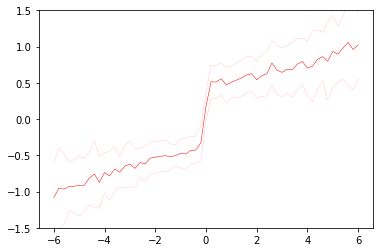

In [9]:
# MC dropout uncertainty figure
plt.figure()
mean = np.mean(repeat_predictions, 0)
std = np.std(repeat_predictions, 0)
plt.plot(x_test, mean, color='red', lw=0.5)
plt.plot(x_test, mean - std, color='red', lw=0.5, alpha=0.2)
plt.plot(x_test, mean + std, color='red', lw=0.5, alpha=0.2)
plt.ylim([-1.5, 1.5])
plt.show()